# Pitch Detection

Jonathan Forhan

The discrete Fourier transform (DFT) is used in various applications for signal processing. The discrete Fourier transform is defined by the equation:

$$X[m]=\displaystyle\sum^{N-1}_{n=0}x[n]W^{nm}\tag{1}$$

where $W:=e^{-j2\pi/N}.$ Traditional DFT algorithms have a time complexity of $O(n^2)$, making them unfeasible for large data sets, however, in a 1965 paper the Cooley-Tukey algorithm was published. The Cooley-Tukey algorithm is a __fast Fourier transform__ algorithm which reduced the number of redundant matrix computations in the traditional DFT algorithm to yield an $O(n\log(n))$ time complexity. This __fast Fourier transform__ is the subject of this project, namely using it to find fundamental frequencies of various signals.

In [1567]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np
import csv

PIANO1_BREAKS = [0, 35000, 61500]  # indices of piano note seperates
PIANO2_BREAKS = [0, 35000, 64000]

MARGIN = 1.2            # graph margin
ARROW_STYLE = {"facecolor": "black", "arrowstyle": "->"}
SAMPLE_RATE = 44_100    # 44.1 kHz
INT16_MAX = (2**15)-1   # Use INT16_MAX to match csv normalization because the wav file has 16-bits per sample
                        # This is stored in the header extracted using `$ exiftool ./$WAV_FILE > $WAV_FILE.metadata.txt`

def signal_fft(signal: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    spec = np.abs(np.fft.fft(signal))
    freq = np.fft.fftfreq(len(spec), 1/SAMPLE_RATE)

    # trim negatives
    spec = spec[:len(spec)//2]
    freq = freq[:len(freq)//2]
    return freq, spec


# read signal from file, supports .wav and .csv
def read_signal(path: str, *, ft: str, fft=False) -> tuple[np.ndarray, np.ndarray]:
    match ft:
        case "wav":
            _, signal = wavfile.read(path)
            signal = signal / INT16_MAX
        case "csv":
            with open(path, newline="") as file:
                reader = csv.reader(file, delimiter=",")
                signal = next(reader) # only one entry
                signal = [float(pt) for pt in signal]
        case _:
            raise IOError("bad filetype")

    if fft:
        freq, spec = signal_fft(signal)
    else:
        freq, spec = np.fft.fftfreq(len(signal), 1/SAMPLE_RATE), signal

    return freq, spec


# take in array and return peak values using a sliding window algorithm
def find_peaks(arr: np.ndarray, floor=10, min_width=5, min_val=80) -> list[int]:
    peaks: list[int] = []
    l, r = 0, 1  # left and right of sliding window

    while r < len(arr):
        if arr[r] < floor:
            # only add peaks across greater length than min_width elements and larger tham min_val
            if l < r-min_width:
                np.max(arr[l:r]) > min_val and peaks.append(l+np.argmax(arr[l:r]))
            l = r-1  # reset left ptr if not in active peak
        r += 1       # increment right ptr
    
    return peaks


# chop a signal at indices
def chop_signal(signal: np.ndarray, indices: list[int]) -> list[np.ndarray]:
    indices.append(-1)
    chopped = [signal[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return chopped



In [1568]:
# @title Audio Samples
from IPython.display import Audio, display

for file in "trumpet.csv", "twotrumpetsAB.csv", "piano1_mono.wav", "piano2_mono.wav":
    _, signal = read_signal(f"res/{file}", ft=file[-3:])
    display(Audio(signal, rate=SAMPLE_RATE))

_, signal = read_signal("res/piano1_mono.wav", ft="wav")
chopped_piano1 = chop_signal(signal, PIANO1_BREAKS)

_, signal = read_signal("res/piano2_mono.wav", ft="wav")
chopped_piano2 = chop_signal(signal, PIANO2_BREAKS)

print("Piano 1 seperate")
_ = [display(Audio(sig, rate=SAMPLE_RATE)) for sig in chopped_piano1]

print("Piano 2 seperate")
_ = [display(Audio(sig, rate=SAMPLE_RATE)) for sig in chopped_piano2]

Piano 1 seperate


Piano 2 seperate


## Trumpet FFT

|Frequecies (Hz)|Note|
|:--------------|:---|
|491.23         |B   |

<Figure size 432x288 with 0 Axes>

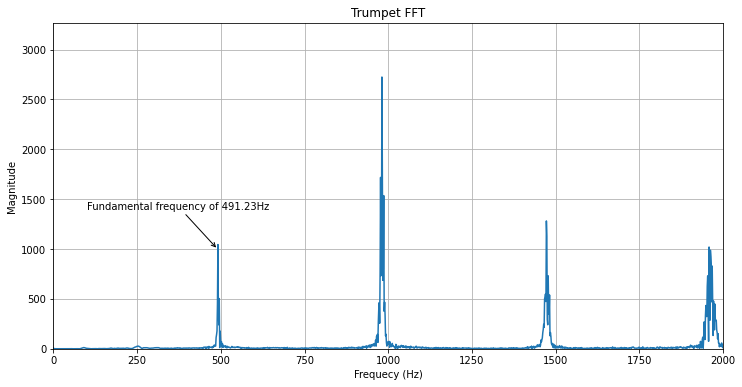

In [1569]:
RANGE=2000

freq, spec = read_signal("res/trumpet.csv", ft="csv", fft=True)
ymax = np.max(spec)

plt.clf()
plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Trumpet FFT")
plt.axis((0, RANGE, 0, ymax * MARGIN))
plt.xlabel("Frequecy (Hz)")
plt.ylabel("Magnitude")

peaks = find_peaks(spec[:RANGE])
peakstr = "Fundamental frequency of %0.2fHz" % freq[peaks[0]]
plt.annotate(peakstr, xy=(490, 1000), xytext=(100, 1400), arrowprops=ARROW_STYLE)

plt.plot(freq, spec)

## Two Trumpets FFT

|Frequecies (Hz)|Note|
|:--------------|:---|
|437.39         |A   |
|491.23         |B   |

These frequencies are simultaneous

<Figure size 432x288 with 0 Axes>

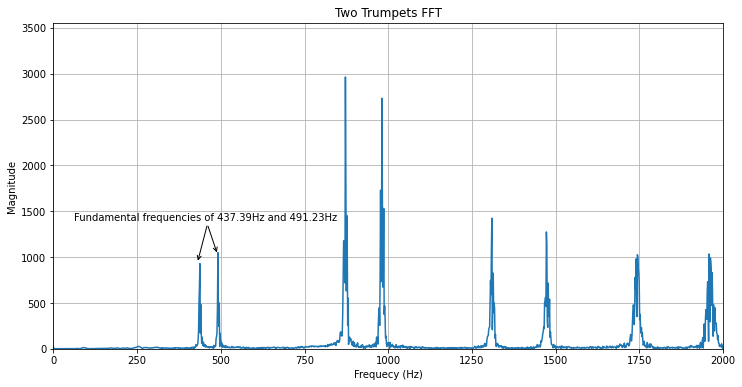

In [1570]:
RANGE=2000

freq, spec = read_signal("res/twotrumpetsAB.csv", ft="csv", fft=True)
ymax = np.max(spec)

plt.clf()
plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Two Trumpets FFT")
plt.axis((0, RANGE, 0, ymax * MARGIN))
plt.xlabel("Frequecy (Hz)")
plt.ylabel("Magnitude")

peaks = find_peaks(spec[:RANGE])
peakstr = "Fundamental frequencies of %0.2fHz and %0.2fHz" % (freq[peaks[0]], freq[peaks[1]])
plt.annotate(peakstr, xy=(490, 1030), xytext=(60, 1400), arrowprops=ARROW_STYLE)
plt.annotate(None, xy=(430, 940), xytext=(460, 1360), arrowprops=ARROW_STYLE)
plt.plot(freq, spec)

## Piano 1 FFT

|Frequecies (Hz)|Note|
|:--------------|:---|
|91.98          |F#  |
|116.49         |A#  |
|138.00         |C#  |

These frequencies are sequential

<Figure size 432x288 with 0 Axes>

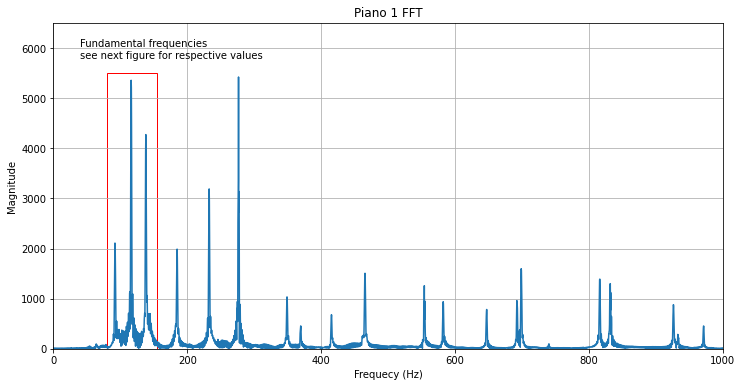

<Figure size 432x288 with 0 Axes>

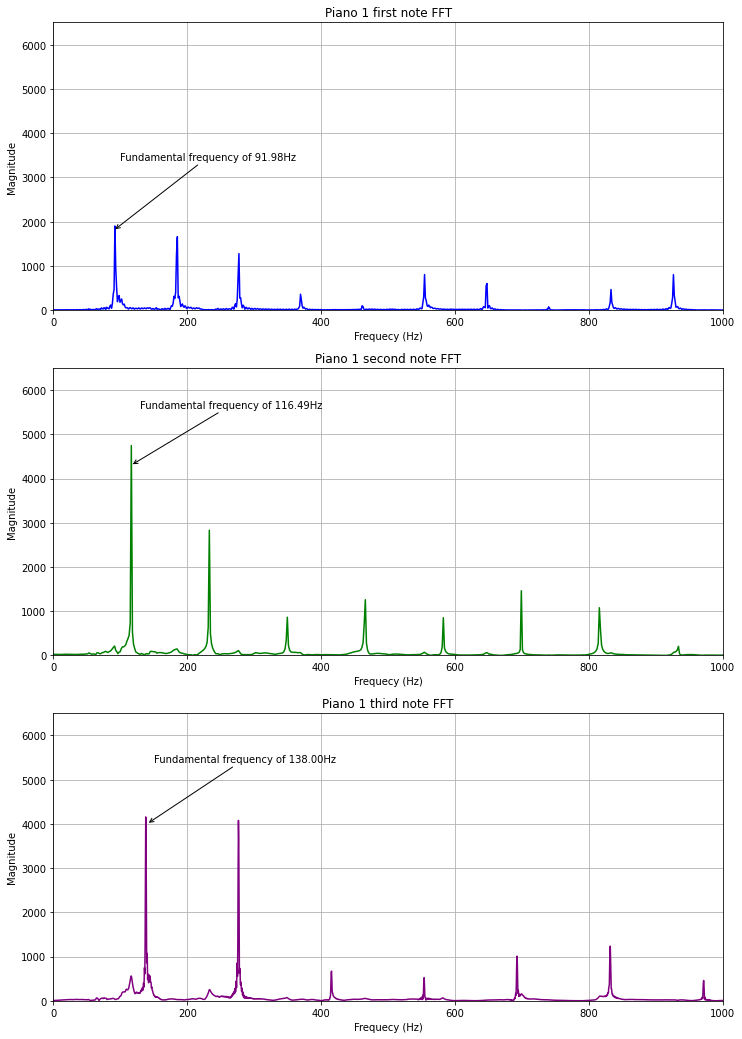

In [1571]:
RANGE=1000

freq, spec = read_signal("res/piano1_mono.wav", ft="wav", fft=True)
ymax = np.max(spec)

plt.clf()
plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Piano 1 FFT")
plt.axis((0, RANGE, 0, ymax * MARGIN))
plt.xlabel("Frequecy (Hz)")
plt.ylabel("Magnitude")

rect = patches.Rectangle((80, 0), 75, 5500, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(40, 5800, "Fundamental frequencies\nsee next figure for respective values")

plt.plot(freq, spec)
plt.show()

# piano 1 chopped
_, signal = read_signal("res/piano1_mono.wav", ft="wav", fft=False)
signals = chop_signal(signal, PIANO1_BREAKS)  # new chopped signals

plt.clf()
plt.figure(figsize=(12, 18))

colors = ["blue", "green", "purple"]
xys = [
    (90, 1800),
    (116, 4300),
    (140, 4000)
]
xytexts = [
    (100, 3400),
    (130, 5600),
    (150, 5400)
]

for i, note in enumerate(["first", "second", "third"]):
    plt.subplot(311+i)
    plt.grid()
    plt.title(f"Piano 1 {note} note FFT")
    plt.axis((0, RANGE, 0, ymax * MARGIN))
    plt.xlabel("Frequecy (Hz)")
    plt.ylabel("Magnitude")

    freq, spec = signal_fft(signals[i])
    peaks = find_peaks(spec[:RANGE])
    peaks = [freq[pk] for pk in peaks]

    peaks = find_peaks(spec[:RANGE])
    peakstr = "Fundamental frequency of %0.2fHz" % freq[peaks[0]]
    plt.annotate(peakstr, xy=xys[i], xytext=xytexts[i], arrowprops=ARROW_STYLE)

    plt.plot(freq, spec, colors[i])

## Piano 2 FFT

|Frequency (Hz)     |Note|
|:------------------|:---|
|91.98              |F#  |
|115.57             |A#  |
|137.98             |C#  |

These frequencies are sequential

<Figure size 432x288 with 0 Axes>

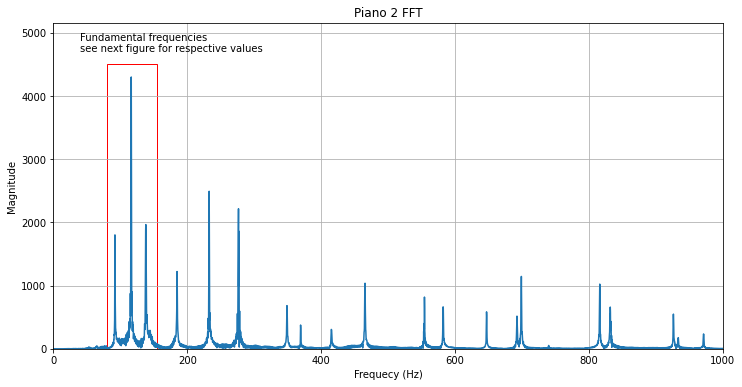

<Figure size 432x288 with 0 Axes>

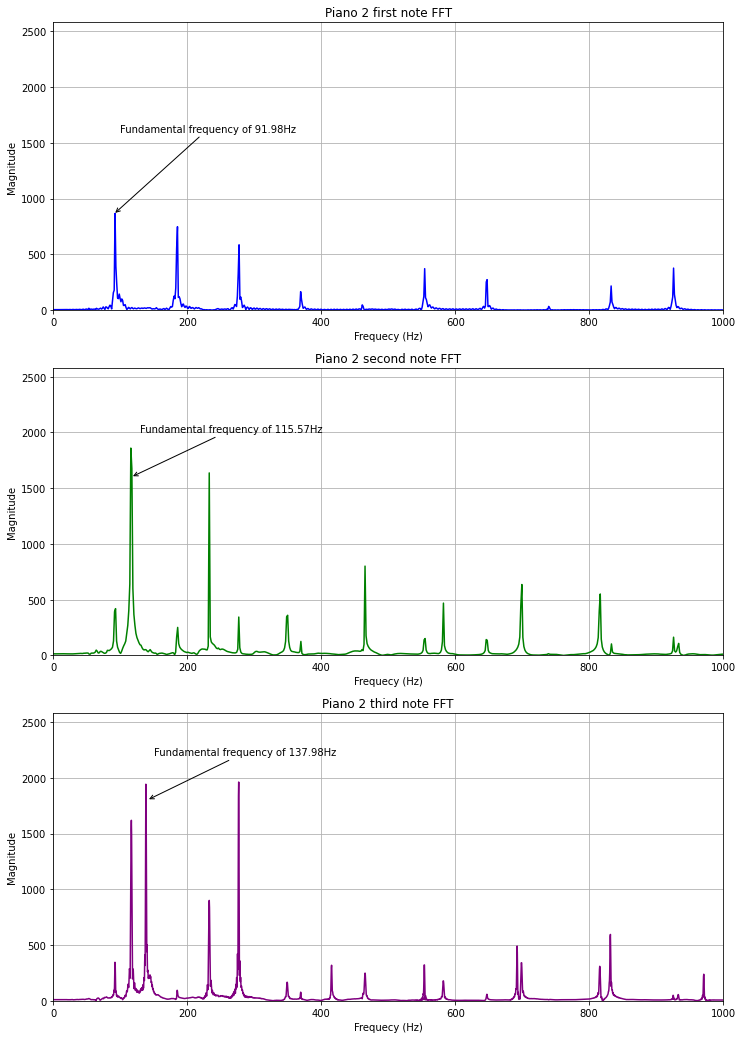

In [1572]:
RANGE=1000

freq, spec = read_signal("res/piano2_mono.wav", ft="wav", fft=True)
ymax = np.max(spec)

plt.clf()
plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Piano 2 FFT")
plt.axis((0, RANGE, 0, ymax * MARGIN))
plt.xlabel("Frequecy (Hz)")
plt.ylabel("Magnitude")

rect = patches.Rectangle((80, 0), 75, 4500, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(40, 4700, "Fundamental frequencies\nsee next figure for respective values")

plt.plot(freq, spec)
plt.show()

# piano 2 chopped
ymax = np.max(spec) / 2
_, signal = read_signal("res/piano2_mono.wav", ft="wav", fft=False)
signals = chop_signal(signal, PIANO2_BREAKS)  # new chopped signals

plt.clf()
plt.figure(figsize=(12, 18))

colors = ["blue", "green", "purple"]
xys = [
    (90, 860),
    (116, 1600),
    (140, 1800)
]
xytexts = [
    (100, 1600),
    (130, 2000),
    (150, 2200)
]

for i, note in enumerate(["first", "second", "third"]):
    plt.subplot(311+i)
    plt.grid()
    plt.title(f"Piano 2 {note} note FFT")
    plt.axis((0, RANGE, 0, ymax * MARGIN))
    plt.xlabel("Frequecy (Hz)")
    plt.ylabel("Magnitude")

    freq, spec = signal_fft(signals[i])
    peaks = find_peaks(spec[:RANGE])
    peaks = [freq[pk] for pk in peaks]

    peaks = find_peaks(spec[:RANGE], floor=100)
    peakstr = "Fundamental frequency of %0.2fHz" % freq[peaks[i]] # index of i happens to work, just as lucky as [0]
    plt.annotate(peakstr, xy=xys[i], xytext=xytexts[i], arrowprops=ARROW_STYLE)

    plt.plot(freq, spec, colors[i])